# GR00T Inference

This tutorial shows how to use the GR00T inference model to predict the actions from the observations, given a test dataset.

In [1]:
import os
import torch
import gr00t

from gr00t.data.dataset import LeRobotSingleDataset
from gr00t.model.policy import Gr00tPolicy

/home/saphari_lab/anaconda3/envs/gr00t/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/saphari_lab/anaconda3/envs/gr00t/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/home/saphari_lab/anaconda3/envs/gr00t/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/

In [3]:
# change the following paths
MODEL_PATH = "nvidia/GR00T-N1-2B"

# REPO_PATH is the path of the pip install gr00t repo and one level up
REPO_PATH = os.path.dirname(os.path.dirname(gr00t.__file__))
DATASET_PATH = os.path.join(REPO_PATH, "novideo_data")
EMBODIMENT_TAG = "gr1"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


## Loading Pretrained Policy

Policy Model is loaded just like any other huggingface model.

There are 2 new concepts here in the GR00T model:
 - modality config: This defines the keys in the dictionary used by the model. (e.g. `action`, `state`, `annotation`, `video`)
 - modality_transform: A sequence of transform which are used during dataloading

In [4]:
from gr00t.experiment.data_config import DATA_CONFIG_MAP
from gr00t.data.dataset import ModalityConfig

data_config = DATA_CONFIG_MAP["gr1_arms_only"]
print(data_config)
print(data_config.modality_config())
modality_config = data_config.modality_config()
modality_transform = data_config.transform()
modality_config = {
    "video": ModalityConfig(
        delta_indices=[0],
        modality_keys=["video.ego_view"],
    ),
    "state": ModalityConfig(
        delta_indices=[0],
        modality_keys=[
            "state.left_arm",
            "state.right_arm"
        ],
    ),
    "action": ModalityConfig(
        delta_indices=[0],
        modality_keys=[
            "action.left_arm",
            "action.right_arm",
        ],
    ),
    "language": ModalityConfig(
        delta_indices=[0],
        modality_keys=["annotation.human.action.task_description", "annotation.human.validity"],
    ),
}
policy = Gr00tPolicy(
    model_path=MODEL_PATH,
    embodiment_tag=EMBODIMENT_TAG,
    modality_config=modality_config,
    modality_transform=modality_transform,
    device=device,
)

# print out the policy model architecture
print(policy.model)

2025-04-07 14:21:38.003595: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 14:21:38.022779: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-07 14:21:38.022802: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-07 14:21:38.023513: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-07 14:21:38.027261: I tensorflow/core/platform/cpu_feature_guar

{'video': ModalityConfig(delta_indices=[0], modality_keys=['video.ego_view']), 'state': ModalityConfig(delta_indices=[0], modality_keys=['state.left_arm', 'state.right_arm', 'state.left_hand', 'state.right_hand']), 'action': ModalityConfig(delta_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], modality_keys=['action.left_arm', 'action.right_arm', 'action.left_hand', 'action.right_hand']), 'language': ModalityConfig(delta_indices=[0], modality_keys=['annotation.human.action.task_description'])}


Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 49539.02it/s]


Loading pretrained dual brain from /home/saphari_lab/.cache/huggingface/hub/models--nvidia--GR00T-N1-2B/snapshots/32e1fd2507f7739fad443e6b449c8188e0e02fcb
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action head DiT: True
Model not found or avail in the huggingface hub. Loading from local path: /home/saphari_lab/.cache/huggingface/hub/models--nvidia--GR00T-N1-2B/snapshots/32e1fd2507f7739fad443e6b449c8188e0e02fcb


ValueError: FlashAttention2 has been toggled on, but it cannot be used due to the following error: Flash Attention 2 is not available on CPU. Please make sure torch can access a CUDA device.

## Loading dataset

First this requires user to check which embodiment tags are used to pretrained the `Gr00tPolicy` pretrained models.

In [ ]:
import numpy as np

modality_config = policy.modality_config

print(modality_config.keys())

for key, value in modality_config.items():
    if isinstance(value, np.ndarray):
        print(key, value.shape)
    else:
        print(key, value)


dict_keys(['video', 'state', 'action', 'language'])
video delta_indices=[0] modality_keys=['video.ego_view']
state delta_indices=[0] modality_keys=['state.left_arm', 'state.right_arm']
action delta_indices=[0] modality_keys=['action.left_arm', 'action.right_arm']
language delta_indices=[0] modality_keys=['annotation.human.action.task_description', 'annotation.human.validity']


In [ ]:
# Create the dataset
dataset = LeRobotSingleDataset(
    dataset_path=DATASET_PATH,
    modality_configs=modality_config,
    video_backend="decord",
    video_backend_kwargs=None,
    transforms=None,  # We'll handle transforms separately through the policy
    embodiment_tag=EMBODIMENT_TAG,
)

Initialized dataset novideo_data with gr1


Let's print out a single data and visualize it

In [ ]:
import numpy as np

step_data = dataset[0]

print(step_data)

print("\n\n ====================================")
for key, value in step_data.items():
    if isinstance(value, np.ndarray):
        print(key, value.shape)
    else:
        print(key, value)


0 video.ego_view 0
{'video.ego_view': array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]]], dtype=uint8), 'state.left_arm': array([[ 0.29452433,  0.88737322,  0.01875967,  0.58670506,  0.42106754,
        -0.16927454, -0.46

Let's plot just the "right hand" state and action data and see how it looks like. Also show the images of the right hand state.

0 video.ego_view 0
0 video.ego_view 1
0 video.ego_view 2
0 video.ego_view 3
0 video.ego_view 4
0 video.ego_view 5
0 video.ego_view 6
0 video.ego_view 7
0 video.ego_view 8
0 video.ego_view 9
0 video.ego_view 10
0 video.ego_view 11
0 video.ego_view 12
0 video.ego_view 13
0 video.ego_view 14
0 video.ego_view 15
0 video.ego_view 16
0 video.ego_view 17
0 video.ego_view 18
0 video.ego_view 19
0 video.ego_view 20
0 video.ego_view 21
0 video.ego_view 22
0 video.ego_view 23
0 video.ego_view 24
0 video.ego_view 25
0 video.ego_view 26
0 video.ego_view 27
0 video.ego_view 28
0 video.ego_view 29
0 video.ego_view 30
0 video.ego_view 31
0 video.ego_view 32
0 video.ego_view 33
0 video.ego_view 34
0 video.ego_view 35
0 video.ego_view 36
0 video.ego_view 37
0 video.ego_view 38
0 video.ego_view 39
0 video.ego_view 40
0 video.ego_view 41
0 video.ego_view 42
0 video.ego_view 43
0 video.ego_view 44
0 video.ego_view 45
0 video.ego_view 46
0 video.ego_view 47
0 video.ego_view 48
0 video.ego_view 49
0 video.eg

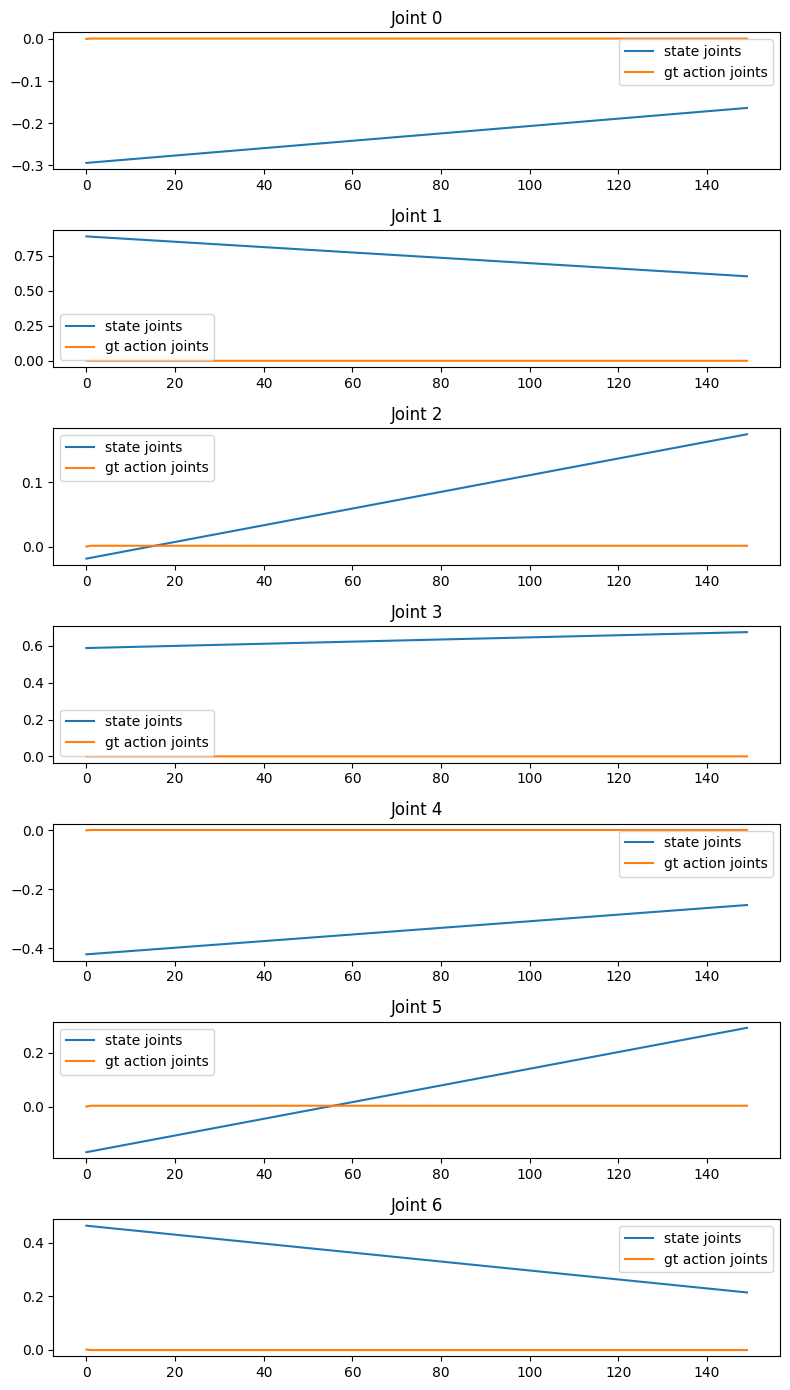

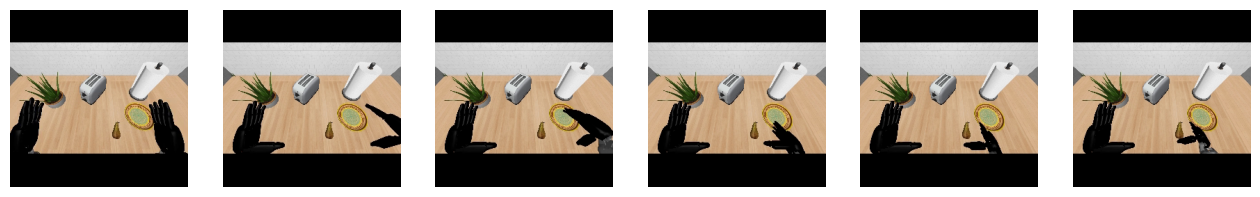

In [ ]:
import matplotlib.pyplot as plt

traj_id = 0
max_steps = 150

state_joints_across_time = []
gt_action_joints_across_time = []
images = []

sample_images = 6

for step_count in range(max_steps):
    data_point = dataset.get_step_data(traj_id, step_count)
    state_joints = data_point["state.right_arm"][0]
    gt_action_joints = data_point["action.right_arm"][0]
    
   
    state_joints_across_time.append(state_joints)
    gt_action_joints_across_time.append(gt_action_joints)

    # We can also get the image data
    if step_count % (max_steps // sample_images) == 0:
        image = data_point["video.ego_view"][0]
        images.append(image)

# Size is (max_steps, num_joints == 7)
state_joints_across_time = np.array(state_joints_across_time)
gt_action_joints_across_time = np.array(gt_action_joints_across_time)


# Plot the joint angles across time
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(8, 2*7))

for i, ax in enumerate(axes):
    ax.plot(state_joints_across_time[:, i], label="state joints")
    ax.plot(gt_action_joints_across_time[:, i], label="gt action joints")
    ax.set_title(f"Joint {i}")
    ax.legend()

plt.tight_layout()
plt.show()


# Plot the images in a row
fig, axes = plt.subplots(nrows=1, ncols=sample_images, figsize=(16, 4))

for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.axis("off")
    

Now we can run the policy from the pretrained checkpoint.

In [ ]:
predicted_action = policy.get_action(step_data)
values = True
for key, value in predicted_action.items():
    print(key, value.shape)
    if values is True:
        values = value
print(values)

ValueError: Error applying transform 9 to data: keys in state_concat_order are misspecified, 
state_keys=['state.left_arm', 'state.right_arm'], 
self.state_concat_order=['state.left_arm', 'state.right_arm', 'state.left_hand', 'state.right_hand']

### Understanding the Action Output

Each joint in the action output has a shape of (16, N) where N is the degree of freedom for the joint.
- 16 represents the action horizon (predictions for timesteps t, t+1, t+2, ..., t+15)

For each arm (left and right):
- 7 arm joints:
  - Shoulder pitch
  - Shoulder roll
  - Shoulder yaw
  - Elbow pitch
  - Wrist yaw
  - Wrist roll
  - Wrist pitch

For each hand (left and right):
- 6 finger joints:
  - Little finger
  - Ring finger
  - Middle finger
  - Index finger
  - Thumb rotation
  - Thumb bending

For the waist
- 3 joints:
  - torso waist yaw
  - torso waist pitch
  - torso waist roll
